# 07 - Clustering projections

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import os

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [2]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 200

learning_rate   = 1
min_len         = 30
mode            = 'single'
starting_bp     = [165, 264]

overwrite_results = True

In [3]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
results_path_file   = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters_PROJECTIONS_SHORT_TERM.nc'
results_path_image  = f'../data/results/images/clustering_results_{n_seasons}seas_{n_iters}iters_PROJECTIONS_SHORT_TERM.png'

if os.path.exists(results_path_file) and overwrite_results:
    results_exist = True
    print('Results already stored! - Overwriting')

if os.path.exists(results_path_file) and not overwrite_results:
    results_exist = True
    print('Results already stored! - Skipping clustering')

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [4]:
base_path = '../data/preprocessed/CMIP6'

models = [
    'EC-Earth3',
    # 'AWI-CM-1-1-MR',
    'MIROC6',
    'INM-CM5-0',
    'CMCC-ESM2',
    'ACCESS-ESM1-5',
    # 'MPI-ESM1-2-HR'
      ]

experiments = ['ssp585']
variables = ['tas', 'pr']

terms = ['short_term_2020-2040', 'medium_term_2040-2070','long_term_2070-2100']

tot_res = []
for model in models:
    
    model_res = []
    for experiment in experiments:

        
        for term, term_time in zip(terms, [2030,2050,2100]):
            dataset_t2m = xr.open_mfdataset(rf'{base_path}/{model}/{experiment}/tas/{term}.nc')['tas'].load()
            dataset_tp = xr.open_mfdataset(rf'{base_path}/{model}/{experiment}/pr/{term}.nc').pr.load()


            dataset_tp['time'] = dataset_t2m['time']

            datasets = [dataset_tp, dataset_t2m]  # Add as many datasets as needed

            clustering_params = {
                'iters': n_iters,
                'n_seas': n_seasons,
                'learning_rate': learning_rate,
                'min_len': min_len,
                'mode': mode,
                'starting_bp': starting_bp,
            }

            result = XRCC(datasets, **clustering_params)
            model_res.append(result.assign_coords(term=term_time))
        
    model_res = xr.concat(model_res, dim='term').assign_coords(model=model)
    tot_res.append(model_res)

tot_res = xr.concat(tot_res, dim='model')

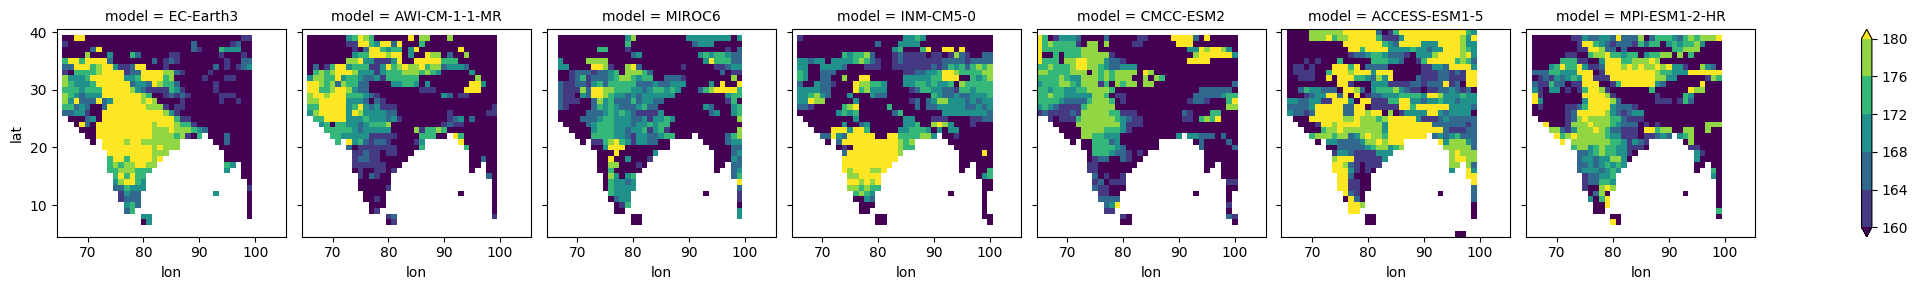

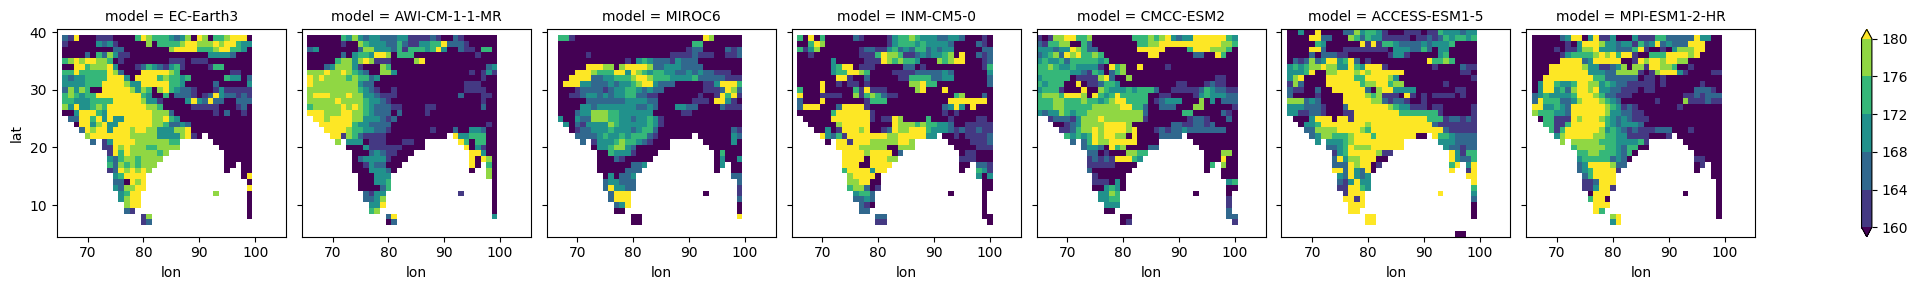

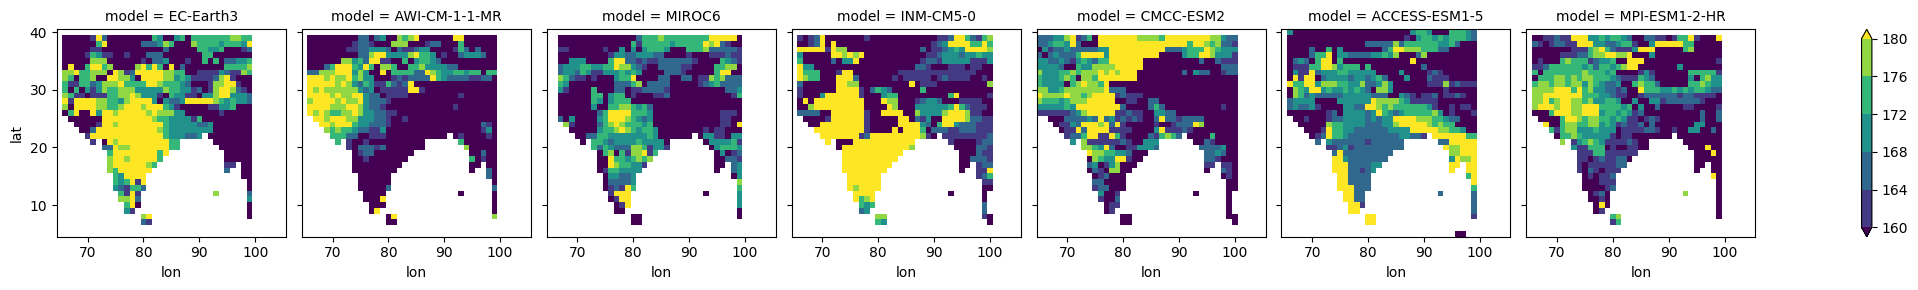

In [5]:
for j in range(3):
    tot_res.sel(cluster=0).isel(term=j).plot(col='model', vmin=160, vmax=180, levels=6)

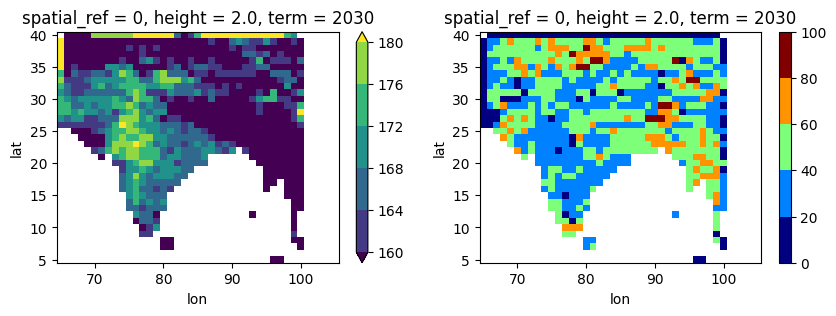

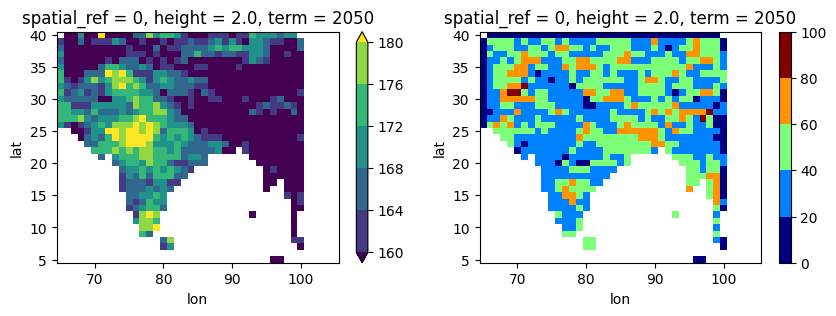

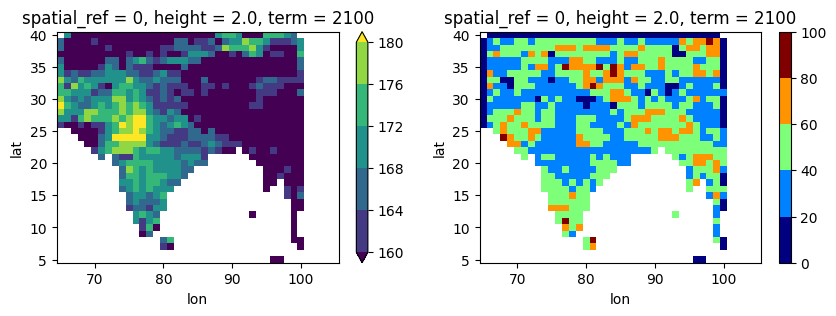

In [6]:
for j in range(3):
    fig, ax = plt.subplots(1,2, figsize=(10,3))
    tot_res.sel(cluster=0).isel(term=j).mean('model').plot(vmin=160, vmax=180, levels=6, ax=ax[0], cmap='viridis')
    (tot_res.sel(cluster=0).isel(term=j).max('model') - tot_res.sel(cluster=0).isel(term=j).min('model')).plot(levels=6, ax=ax[1], cmap='jet')

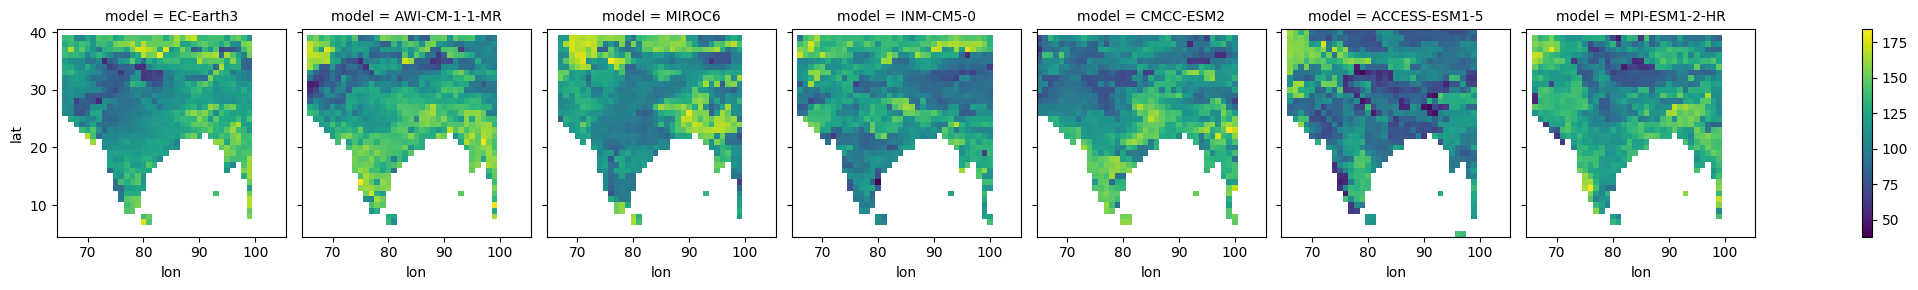

In [7]:
len = tot_res.sel(cluster=1) - tot_res.sel(cluster=0)

len.isel(term=0).plot(col='model')

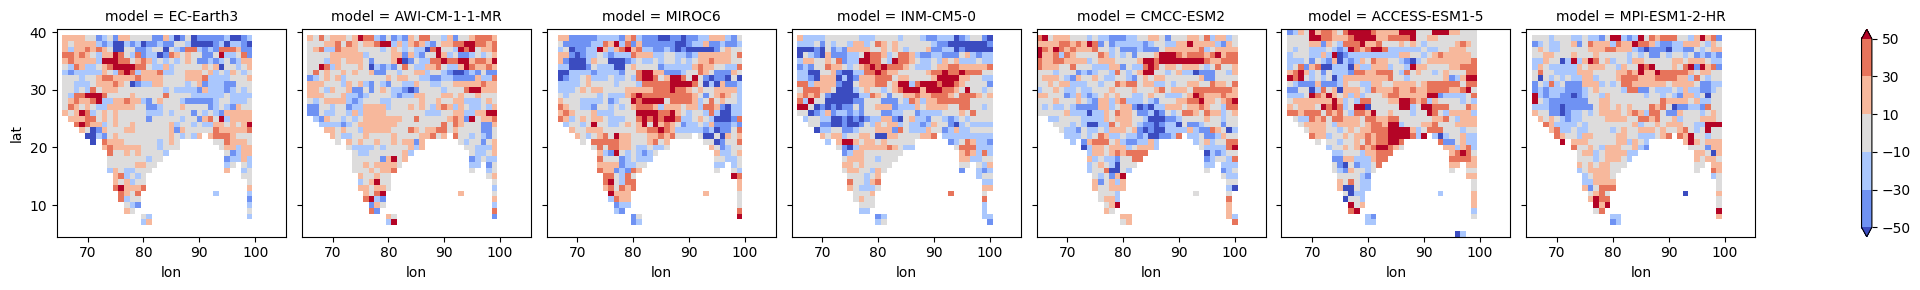

In [8]:
len_diff = len.isel(term=-1) - len.isel(term=0)

len_diff.plot(col='model', vmin=-50, vmax=50, cmap='coolwarm', levels=6)

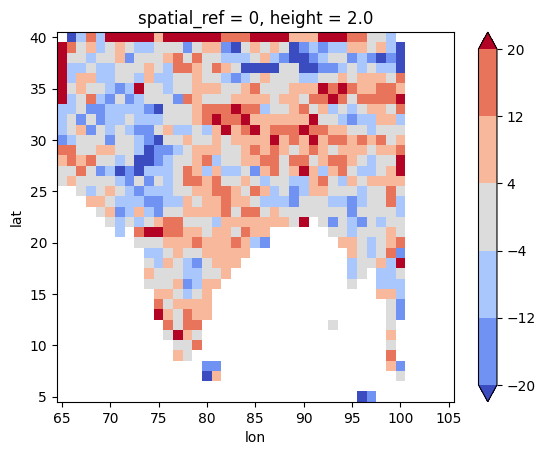

In [14]:
len_diff.mean('model').plot(vmin=-20, vmax=20, cmap='coolwarm', levels=6)

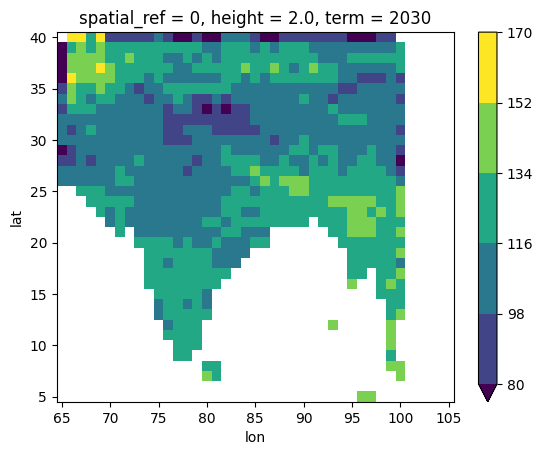

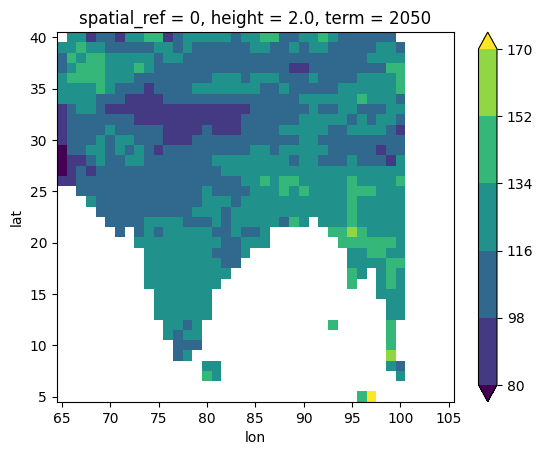

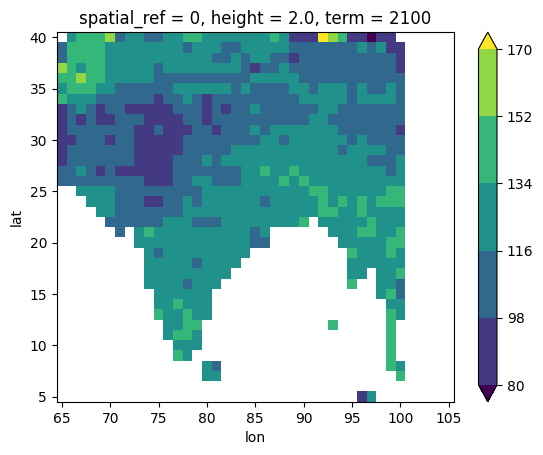

In [9]:
for j in range(3):
    plt.figure()
    (tot_res.sel(cluster=1).isel(term=j).mean('model') - tot_res.sel(cluster=0).isel(term=j).mean('model')).plot(levels=6, cmap='viridis', vmin=80, vmax=170)